In [17]:
import tvm
from tvm import te
from tvm import relay, transform
from tvm.contrib import graph_executor as runtime
from pathlib import Path
import onnx
import imageio
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
model_path = Path.cwd().parent / 'models' / 'insightface_facealignment' / '2d106det.onnx'
model_path.exists()

True

In [4]:
onnx_model = onnx.load(str(model_path))

In [5]:
onnx_model.graph.input

[name: "data"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_param: "None"
      }
      dim {
        dim_value: 3
      }
      dim {
        dim_value: 192
      }
      dim {
        dim_value: 192
      }
    }
  }
}
]

In [82]:
onnx_model.graph.output

[name: "fc1"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_value: 1
      }
      dim {
        dim_value: 212
      }
    }
  }
}
]

In [6]:
target = "llvm"

input_name = "data"
input_dtype = "float32"
input_shape = (1, 3, 192, 192)
shape_dict = {input_name: input_shape}
mod, params = relay.frontend.from_onnx(onnx_model, shape_dict, freeze_params=True)

target = "llvm"
with transform.PassContext(opt_level=3):
    lib = relay.build(mod, target, params=params)
    lib.export_library(str(model_path.with_suffix(".so")))

One or more operators have not been tuned. Please tune your model for better performance. Use DEBUG logging level to see more details.


In [7]:
module = runtime.GraphModule(lib["default"](tvm.cpu()))

In [24]:
import requests
from PIL import Image
import io

def get_image():
    r = requests.get('https://thispersondoesnotexist.com/image')
    image = np.asarray(Image.open(io.BytesIO(r.content)))
    return image

In [76]:
original_image = get_image()
image = cv2.resize(original_image, (192, 192), cv2.INTER_AREA)
image = image.astype(np.float32)
image = (image / 127.5) - 1.0
image = image.astype(np.float32)
image_data = np.transpose(image, (2, 0, 1))
image_data = image_data[np.newaxis, :]
module.set_input("data", tvm.nd.array(image_data))
module.run()

In [77]:
np.max(image), np.min(image)

(0.92941177, -1.0)

In [83]:
landmarks = np.squeeze(module.get_output(0).numpy())
landmarks = landmarks.reshape(-1,2)
landmarks.shape

(106, 2)

In [79]:
r,c,_ = original_image.shape
print(r/192,c/192)

5.333333333333333 5.333333333333333


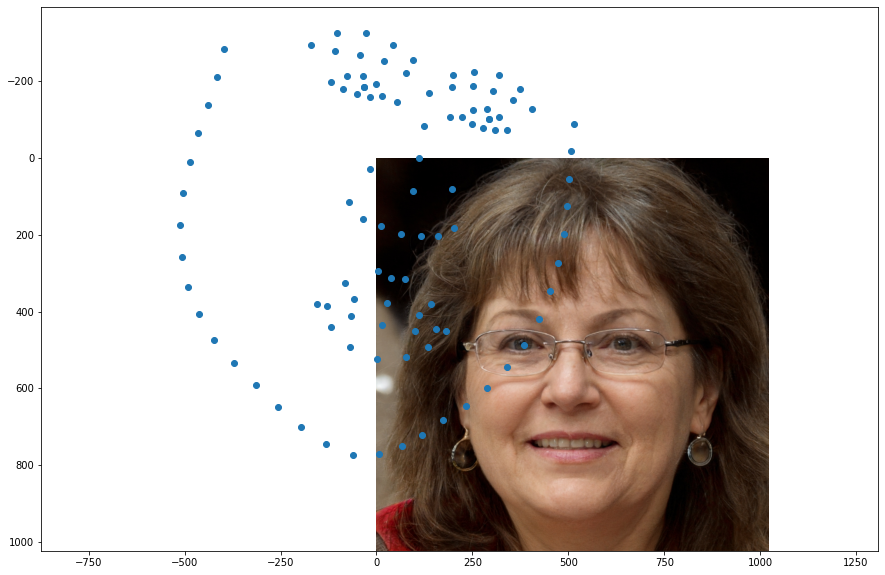

In [81]:
plt.figure(figsize=(15,10))
plt.imshow(original_image)
plt.scatter(landmarks[:,0]*c, landmarks[:,1]*r)
plt.axis('equal')
plt.show()